In [1]:
import numpy as np
import pandas as pd
import torch
from torch import distributions as dist
from tqdm.notebook import tqdm, trange

import statsmodels.formula.api as sm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import berp.synthesize_n400 as syn

In [307]:
DATASET_SIZE = 500
EPOCH_WINDOW = (-0.1, 0.9)
TEST_WINDOW = (0.35, 0.45)

In [308]:
X_word, X_phon, y = syn.sample_dataset_with_phons(DATASET_SIZE)

epochs_df = syn.dataset_to_epochs(X_phon, y, 
                                  epoch_window=EPOCH_WINDOW, 
                                  test_window=TEST_WINDOW)

100%|██████████████████████████████████████████████████████████████| 34338/34338 [02:56<00:00, 194.50it/s]


In [309]:
y_all = epochs_df[["value_N400", "baseline_N400"]].unstack("phon_idx").fillna(0.)
X = X_word.surprisal.values
baseline = y_all.baseline_N400.to_numpy()
y = y_all["value_N400"].to_numpy()
assert len(X) == len(y_all)

## Quick viz

In [310]:
onsets = np.zeros(len(X)).astype(int)
y_0 = y[np.arange(len(X)), onsets]
baseline_0 = baseline[np.arange(len(X)), onsets]

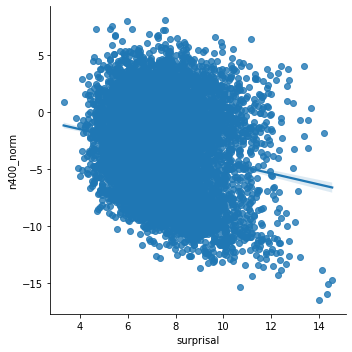

In [311]:
reg_data = pd.DataFrame({"surprisal": X.flatten(), "baseline": baseline_0, 
                         "n400": y_0, "n400_norm": y_0 - baseline_0})
sns.lmplot(data=reg_data, x="surprisal", y="n400_norm")

In [312]:
model = sm.ols("n400 ~ surprisal + baseline", data=reg_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   n400   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     571.5
Date:                Mon, 25 Apr 2022   Prob (F-statistic):          1.20e-233
Time:                        21:24:14   Log-Likelihood:                -22119.
No. Observations:                8538   AIC:                         4.424e+04
Df Residuals:                    8535   BIC:                         4.426e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2115      0.184    -12.031      0.000      -2.572      -1.851
surprisal     -0.4944      0.023    -21.318      0.000      -0.540      -0.449
baseline       0.3105      0.012     26.079      0.000       0.287       0.334
==============================================================================
Omnibus:                    12956.922   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.668
Skew:                          -0.027   Prob(JB):                    4.86e-122
Kurtosis:                       1.748   Cond. No.                         46.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Alternating regression

In [313]:
word_lengths = X_phon.groupby(["item", "word_idx"]).size().to_numpy()
max_onsets = word_lengths - 1
# Pre-compute mask over (n_word, n_phon) matrix nulling out any n_phon columns which extend
# past word length for the corresponding word.
# Contains `False` where word-phoneme entry should be considered, and `True` elsewhere
y_mask = np.tile(np.arange(y.shape[1]), (y.shape[0], 1)) > max_onsets[:, np.newaxis]

In [315]:
n_iter = 20
# onsets = np.zeros(len(X)).astype(int)
onsets = np.random.randint(np.zeros(len(X)), max_onsets + 1)
best_mse, best_onsets = np.inf, None
for _ in trange(n_iter):
    model_fit = sm.ols(
        "n400 ~ surprisal + baseline",
        {"n400": y[np.arange(y.shape[0]), onsets],
         "baseline": baseline[np.arange(y.shape[0]), onsets],
         "surprisal": X}).fit()
    print(model_fit.mse_total, model_fit.params.loc["surprisal"])
    
    if model_fit.mse_total < best_mse:
        best_mse = model_fit.mse_total
        best_onsets = onsets
    
    # Compute residuals over all possible onset indices.
    l2 = y.copy()
    for onset in range(y.shape[1]):
        preds = model_fit.predict({"surprisal": X,
                                   "baseline": baseline[:, onset]})
        l2[:, onset] = (y[:, onset] - preds) ** 2
     
    # Don't allow anything past allowed onsets per word to be chosen.
    l2[y_mask] = np.nan
    onsets = np.nanargmin(l2, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

10.177207224743015 -0.6222604696044303
3.2748197368844414 -0.7777626591660672
3.1118430242330906 -0.8894576828675875
3.187071041895676 -0.9553356695543219
3.3163910699652397 -0.9993890992837413
3.414115249633525 -1.025050950075097
3.4683586610227266 -1.0322254648222817
3.4970907648923792 -1.0319036737568004
3.517334205657824 -1.0301081537944303
3.5255053763943693 -1.02663902436877
3.5340727833710006 -1.023174832507988
3.5618614277020693 -1.0224103151490174
3.5810746492594756 -1.0218269352012188
3.604735142327308 -1.0211049848670894
3.6250812217332884 -1.0217468267916767
3.6287323384552232 -1.0198686898929106
3.6301344994337086 -1.018781223339521
3.631953654299819 -1.0184945285372837
3.630965169101395 -1.0172957564290355
3.6321512594082326 -1.0166046408407596


In [316]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   n400   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 1.423e+04
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:24:25   Log-Likelihood:                -11359.
No. Observations:                8538   AIC:                         2.272e+04
Df Residuals:                    8535   BIC:                         2.275e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2271      0.053    -42.014      0.000      -2.331      -2.123
surprisal     -1.0166      0.007   -154.565      0.000      -1.029      -1.004
baseline       0.2475      0.004     69.767      0.000       0.241       0.254
==============================================================================
Omnibus:                      291.863   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.592
Skew:                          -0.343   Prob(JB):                     2.33e-93
Kurtosis:                       3.853   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
X_word["onset_pred"] = onsets

<AxesSubplot:xlabel='recognition_point', ylabel='onset_pred'>

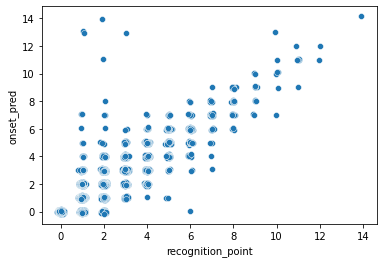

In [318]:
sns.scatterplot(data=X_word[["onset_pred", "recognition_point"]] + np.random.normal(0, 0.05, size=(len(X_word), 2)),
                x="recognition_point", y="onset_pred")

In [319]:
(X_word.recognition_point == X_word.onset_pred).mean()

0.6539002108222066

<AxesSubplot:ylabel='Count'>

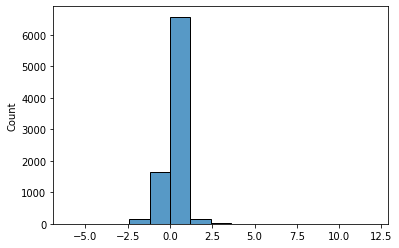

In [320]:
sns.histplot(X_word.onset_pred - X_word.recognition_point)

<AxesSubplot:xlabel='resid_normalized', ylabel='Count'>

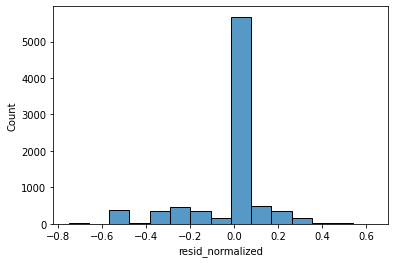

In [328]:
X_word["n_phon"] = X_phon.groupby(["item", "word_idx"]).size()
X_word["resid_normalized"] = (X_word.onset_pred - X_word.recognition_point) / X_word.n_phon
sns.histplot(X_word.resid_normalized)

In [329]:
import scipy.stats as st
st.pearsonr(X_word.recognition_point, X_word.onset_pred)

(0.8872558199049417, 0.0)